<a href="https://colab.research.google.com/github/ahmedtabsho/PytorchTutorial/blob/main/CNNWithPyTorch.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torchvision.utils as make_grid

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import confusion_matrix
%matplotlib inline



In [ ]:
# Convert MNIST Image Files into a Tensor of 4-Dimensions (# of images, Height, Width, Color Channel)
transform = transforms.ToTensor()

In [ ]:
# Train Data
train_data = datasets.MNIST(root='data', train=True, download=True, transform=transform)

In [ ]:
# test Data
test_data = datasets.MNIST(root='data', train=False, download=True, transform=transform)

In [ ]:
train_data

Dataset MNIST
    Number of datapoints: 60000
    Root location: data
    Split: Train
    StandardTransform
Transform: ToTensor()

In [ ]:
test_data

Dataset MNIST
    Number of datapoints: 10000
    Root location: data
    Split: Test
    StandardTransform
Transform: ToTensor()

In [ ]:
pwd

'/content'

In [ ]:
ls

data/  sample_data/


In [ ]:
cd data/

/content/data


In [ ]:
ls

MNIST/


In [ ]:
cd ../

/content


In [ ]:
cd ../

/


In [ ]:
ls

bin@                        datalab/  kaggle/  libx32@                   opt/   sbin@  tools/
boot/                       dev/      lib@     media/                    proc/  srv/   usr/
content/                    etc/      lib32@   mnt/                      root/  sys/   var/
cuda-keyring_1.0-1_all.deb  home/     lib64@   NGC-DL-CONTAINER-LICENSE  run/   tmp/


In [ ]:
cd boot/

/boot


In [ ]:
ls


In [ ]:
cd ../

/


In [ ]:
cd content/

/content


In [ ]:
ls

data/  sample_data/


In [ ]:
# Create a small batch size for images ...let's say 10
train_loader = DataLoader(train_data, batch_size=10, shuffle=True)
test_loader = DataLoader(test_data, batch_size=10, shuffle=False)


In [ ]:
# Define Our CNN Model
# Describe convolutional layer and what it's doing (2 convolutional layers)
conv1 = nn.Conv2d(in_channels = 1, out_channels= 6, kernel_size = 3, stride = 1)
conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5, stride= 1)

In [ ]:
# Grab 1 MNIST record/image
for i, (X_train, y_train) in enumerate(train_data):
    break

In [ ]:
X_train.shape

torch.Size([1, 28, 28])

In [ ]:
x = X_train.view(1,1,28,28)

In [ ]:
# Perform our first convolution
x = F.relu(conv1(x)) # Rectified Linear Unit for our activation funciton


In [ ]:
# 1 single image , 6 is the filters we asked for 26x26
x.shape

torch.Size([1, 6, 26, 26])

In [ ]:
# pass thru the pooling layer
x = F.max_pool2d(x, kernel_size=2)

In [ ]:
x.shape # 26 / 2 = 13

torch.Size([1, 6, 13, 13])

In [ ]:
# Do our second convolutional layer
x = F.relu(conv2(x))

In [ ]:
x.shape # because of padding it becoming 9x9
# Again, we didn't set padding so we lose 4 pixles around the outside of the image

torch.Size([1, 16, 9, 9])

In [ ]:
# Pooling layer
x = F.max_pool2d(x, kernel_size=2)

In [ ]:
x.shape # 9 / 2 = 4.5 ~= 4

torch.Size([1, 16, 4, 4])

In [ ]:
# Model Class
class convulutionalNetwork(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv1 = nn.Conv2d(in_channels = 1, out_channels= 6, kernel_size = 3, stride = 1)
    self.conv2 = nn.Conv2d(in_channels=6, out_channels=16, kernel_size=3, stride= 1)
    # Fully Connected Layer
    self.fc1 = nn.Linear(in_features=5*5*16, out_features=120)
    self.fc2 = nn.Linear(in_features=120, out_features=84)
    self.fc3 = nn.Linear(in_features=84, out_features=10)

  def forward(self, x):
    x = F.relu(self.conv1(x))
    x = F.max_pool2d(x, kernel_size=2)
    x = F.relu(self.conv2(x))
    x = F.max_pool2d(x, kernel_size=2)

    # Re-view to flatten it out
    x = x.view(-1, 5*5*16) # negative one so that we can vary the batch size

    # Pass thru the fully connected layers
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = self.fc3(x)
    return F.log_softmax(x, dim=1)



In [ ]:
# Create an Instance of our Model
torch.manual_seed(41)
model = convulutionalNetwork()
model

convulutionalNetwork(
  (conv1): Conv2d(1, 6, kernel_size=(3, 3), stride=(1, 1))
  (conv2): Conv2d(6, 16, kernel_size=(3, 3), stride=(1, 1))
  (fc1): Linear(in_features=400, out_features=120, bias=True)
  (fc2): Linear(in_features=120, out_features=84, bias=True)
  (fc3): Linear(in_features=84, out_features=10, bias=True)
)

In [ ]:
# Loss Function Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001) # Smaller the Learning Rate,  longer its gonna take to train.

In [ ]:
import time
start_time = time.time()

# Create Variables To Tracks Things
epochs = 5
train_losses = []
test_losses = []
train_correct = []
test_correct = []

# For Loop of Epochs
for i in range(epochs):
  train_loss = 0.0
  test_loss = 0.0
  train_correct_count = 0
  test_correct_count = 0

  # Train Loop
  for b, (X_train, y_train) in enumerate(train_loader):
    b+=1 # start our batches at 1
    y_pred = model(X_train) # get predicted values from the training set. Not flattened
    loss = criterion(y_pred, y_train) # how off are we ? Compare the predictions to correct ansers in y_train

    predicted = torch.max(y_pred.data, 1)[1] # add up the number of correct predictions. Indexed off the first point
    batch_corr = (predicted == y_train).sum() # how many we got correct from this batch. True = 1 , False = 0,  sum those up.
    train_correct_count += batch_corr

    # update our parameters
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    # Print out some results
    if b%600 == 0:
      print(f'Epoch: {i} Batch: {b} Loss: {loss.item()} Accuracy: {train_correct_count/60000}')

  train_losses.append(loss)
  train_correct.append(train_correct_count)


  # Test
  with torch.no_grad(): # No gradient so we don't updae our weights and biases with test data
    for b, (X_test, y_test) in enumerate(test_loader):
      y_val = model(X_test)
      loss = criterion(y_val, y_test)

  loss = criterion(y_val, y_test)
  test_losses.append(loss)
  test_correct.append(test_correct_count)

  #print(f'Epoch: {i} Train Loss: {loss} Test Loss: {loss}')

current_time = time.time()
total = current_time - start_time
print(f'Training Took : {total/60} minutes!')

Epoch: 0 Batch: 600 Loss: 0.16236095130443573 Accuracy: 0.073983334004879
Epoch: 0 Batch: 1200 Loss: 0.1614728718996048 Accuracy: 0.1657833307981491
Epoch: 0 Batch: 1800 Loss: 0.4654846787452698 Accuracy: 0.260616660118103
Epoch: 0 Batch: 2400 Loss: 0.14589151740074158 Accuracy: 0.3561166524887085
Epoch: 0 Batch: 3000 Loss: 0.006829691119492054 Accuracy: 0.45205000042915344
Epoch: 0 Batch: 3600 Loss: 0.39497455954551697 Accuracy: 0.5487833619117737
Epoch: 0 Batch: 4200 Loss: 0.004197136033326387 Accuracy: 0.6453333497047424
Epoch: 0 Batch: 4800 Loss: 0.002539821667596698 Accuracy: 0.7428333163261414
Epoch: 0 Batch: 5400 Loss: 0.10464674234390259 Accuracy: 0.8404333591461182
Epoch: 0 Batch: 6000 Loss: 0.0004664144362322986 Accuracy: 0.9376999735832214
Epoch: 1 Batch: 600 Loss: 0.005691639147698879 Accuracy: 0.09745000302791595
Epoch: 1 Batch: 1200 Loss: 0.2462776154279709 Accuracy: 0.19550000131130219
Epoch: 1 Batch: 1800 Loss: 0.0021117047872394323 Accuracy: 0.29341667890548706
Epoch: 

In [ ]:
train_losses = [i.item() for i in train_losses]
test_losses = [i.item() for i in test_losses ]

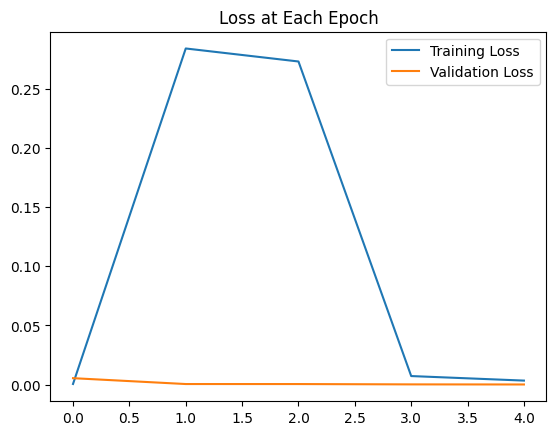

In [ ]:
# Graph the loss at each epoch

plt.plot(train_losses, label='Training Loss')
plt.plot(test_losses, label='Validation Loss')
plt.title('Loss at Each Epoch')
plt.legend()

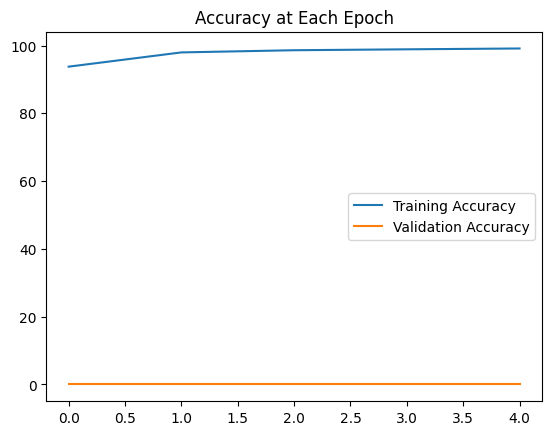

In [ ]:
# Graph the accuracy at the end of each epoch
plt.plot([t/600 for t in train_correct], label='Training Accuracy')
plt.plot([t/600 for t in test_correct], label='Validation Accuracy')
plt.title('Accuracy at Each Epoch')
plt.legend()

In [ ]:
test_load_everything = DataLoader(test_data, batch_size=60000, shuffle=False)

In [ ]:
with torch.no_grad():
  correct = 0
  for X_test, y_test in test_load_everything:
    y_val = model(X_test)
    predicted = torch.max(y_val, 1)[1]
    correct += (predicted == y_test).sum()



In [ ]:
# Did for correct
correct.item()/len(test_data)

0.9852

Text(0.5, 1.0, '7')

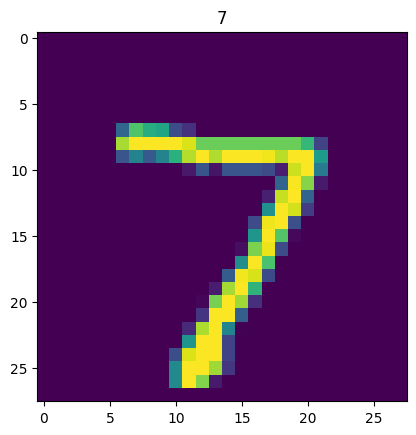

In [ ]:
# Grab an image
image, label = test_data[0]
plt.imshow(image.reshape(28,28))
plt.title(label)

In [ ]:
#Reshape it
test_data[4143][0].reshape(28,28)

tensor([[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000],
        [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
         0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

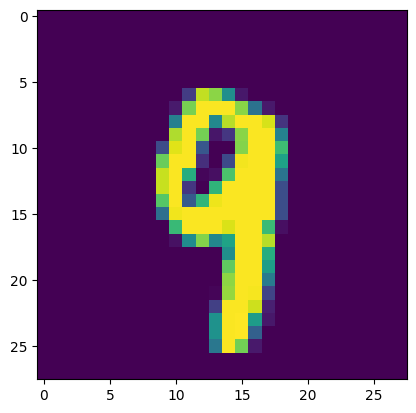

In [ ]:
# show image
plt.imshow(test_data[4143][0].reshape(28,28))

In [ ]:
# pass the image thru our model
model.eval()
with torch.no_grad():
  new_prediction = model(test_data[4143][0].view(1,1,28,28))

In [ ]:
# check the new precition..  get probablities
new_prediction

tensor([[-2.5924e+01, -2.1091e+01, -2.1585e+01, -1.7027e+01, -1.1187e+01,
         -2.1215e+01, -3.4095e+01, -1.5941e+01, -1.5222e+01, -1.4186e-05]])

In [ ]:
new_prediction.argmax()

tensor(9)